# RECOVAR visualization and analysis (mostly copied from cryoDRGN's)

This jupyter notebook provides a template for analyzing results, including:
* plotting of mean, mask and eigenvector
* resolution of mean and decay of eigenvalues
* latent space visualization with PCA/UMAP
* clustering
* trajectories
<!-- * interactive visualization of the latent space, imaging, and pose parameters -->
<!-- * interactive selection of particle images from the latent space -->
<!-- * interactive generation of volumes from the latent space -->

Note that this is a simple template for data analysis, and not a polished UI. Experience with Python/Pandas is recommended.

In [1]:
# import recovar.config
# from importlib import reload
# import numpy as np
# from cryodrgn import analysis
# from cryodrgn import utils
# from cryodrgn import ctf
# from recovar import plot_utils
# from recovar import output, dataset
# import matplotlib.pyplot as plt
# import seaborn as sns
# import plotly.graph_objs as go
# import plotly.offline as py
# from recovar import simulator
# reload(simulator)
# import jax
# import warnings
# # warnings.filterwarnings("error")
# output_folder = "/home/mg6942/mytigress/simulated_normal2/"
# volume_folder_input = "/scratch/gpfs/mg6942/cooperative/models/"
# outlier_file_input = "/home/mg6942/mytigress/simulated_empiar10180/volumes/vol0915.mrc"
# n_images = int(5e4)
# voxel_size = 6
# output.mkdir_safe(output_folder)
# volume_distribution = np.zeros(50)
# first_k = 50
# volume_distribution[:first_k] = 1/first_k
# # volume_distribution[0] = 1
# # volume_distribution[-1] = 1/2
# # volume_distribution = None
# image_stack, sim_info = simulator.generate_synthetic_dataset(output_folder, voxel_size, volume_folder_input, 
#                                                              outlier_file_input, n_images, grid_size = 128,
#                                volume_distribution = volume_distribution,  dataset_params_option = "uniform", noise_level =1e-1, 
#                                noise_model = "white", put_extra_particles = False, percent_outliers = 0.0, 
#                                volume_radius = 0.6, trailing_zero_format_in_vol_name = False, noise_scale_std = 0.2 * 0, contrast_std =0.1 * 0 , disc_type = 'nearest')

# print("dumping to:" + output_folder)


In [2]:
# import jax.numpy as jnp
# import jax
# import numpy as np
# X = jnp.array(np.random.randn(10000,100,100))

# batch_kron = jax.vmap(jnp.kron, in_axes=(0,0))

# @jax.jit
# def summed_batch_kron(X):
#     return jnp.sum(batch_kron(X,X), axis=0)

# @jax.jit
# def summed_batch_kron_scan(X):
#     def fori_loop_body(i, val):
#         return val + jnp.kron(X[i], X[i])
#     summed_kron = jax.lax.fori_loop(0, X.shape[0], fori_loop_body, jnp.zeros([X.shape[-1]**2,X.shape[-1]**2] ))
#     return summed_kron


# %timeit Z = summed_batch_kron(X).block_until_ready()
# # %timeit Z2 = summed_batch_kron_scan(X).block_until_ready()


In [3]:
from importlib import reload
import recovar.config
import pandas as pd
import numpy as np
import pickle
import subprocess
import os, sys

from cryodrgn import analysis
from cryodrgn import utils
# from cryodrgn import dataset
from cryodrgn import ctf
from recovar import plot_utils
from recovar import output, dataset

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from ipywidgets import interact, interactive, HBox, VBox
from scipy.spatial.transform import Rotation as RR
py.init_notebook_mode()
from IPython.display import FileLink, FileLinks

(INFO) (xla_bridge.py) (21-Feb-24 15:03:44) Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
(INFO) (xla_bridge.py) (21-Feb-24 15:03:44) Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
(INFO) (config.py) (21-Feb-24 15:03:44) Devices found: NVIDIA A100-SXM4-80GB


/home/mg6942/.conda/envs/recovar2/lib/python3.9/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(3, 4, 5, 6, 7, 8), but only accepts 8 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
2024-02-21 15:03:52.303752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 15:03:52.303849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 15:03:52.327868: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 15:03:54.1225

### Load result from pipeline.py

In [4]:
# Specify the result dir
output_folder = "/home/mg6942/mytigress/simulated_normal2/"

# recovar_result_dir = '/projects/CRYOEM/singerlab/mg6942/simulated_normal/test/'

recovar_result_dir = "/projects/CRYOEM/singerlab/mg6942/simulated_normal2/test/"
# Load z
results = output.load_results_new(recovar_result_dir)
cryos = dataset.load_dataset_from_args(results['input_args'], lazy = True)
zdim = list(results['zs'].keys())[-1]
print("available zdim:", list(results['zs'].keys()), "using:", zdim)
z = results['zs'][zdim]

(INFO) (dataset.py) (21-Feb-24 15:03:57) Loading halfset from file
(INFO) (ctf.py) (21-Feb-24 15:03:57) Image size (pix)  : 128
(INFO) (ctf.py) (21-Feb-24 15:03:57) A/pix             : 6.0
(INFO) (ctf.py) (21-Feb-24 15:03:57) DefocusU (A)      : 23552.5
(INFO) (ctf.py) (21-Feb-24 15:03:57) DefocusV (A)      : 23740.400390625
(INFO) (ctf.py) (21-Feb-24 15:03:57) Dfang (deg)       : 86.61000061035156
(INFO) (ctf.py) (21-Feb-24 15:03:57) voltage (kV)      : 300.0
(INFO) (ctf.py) (21-Feb-24 15:03:57) cs (mm)           : 2.700000047683716
(INFO) (ctf.py) (21-Feb-24 15:03:57) w                 : 0.07000000029802322
(INFO) (ctf.py) (21-Feb-24 15:03:57) Phase shift (deg) : 0.0
(INFO) (ctf.py) (21-Feb-24 15:03:57) Image size (pix)  : 128
(INFO) (ctf.py) (21-Feb-24 15:03:57) A/pix             : 6.0
(INFO) (ctf.py) (21-Feb-24 15:03:57) DefocusU (A)      : 23552.5
(INFO) (ctf.py) (21-Feb-24 15:03:57) DefocusV (A)      : 23740.400390625
(INFO) (ctf.py) (21-Feb-24 15:03:57) Dfang (deg)       : 86.61

# Diagnostics
* if the mask looks very wrong, it is likely that the uninvert-data is poorly set. 
Use --uninvert-data=true (or false, depending on what you set before). 
If you use automatic, then you can check what it chose and take the oposite by looking at:
print(results['input_args'].uninvert_data)

* If the first eigenvector is mostly positive and looks like the mean, your data might have significant contrast.
Use the --correct-contrast option

* If the one of the eigenvector looks like the mask, your data might have been mean substracted. You may want to use 
Use the --ignore-zero-frequency option

Note that these are options to rectify these problems in case your data has them. The far better option, if applicable, is to just to not normalize your image stack.

<Axes: title={'center': 'mean estimation'}>

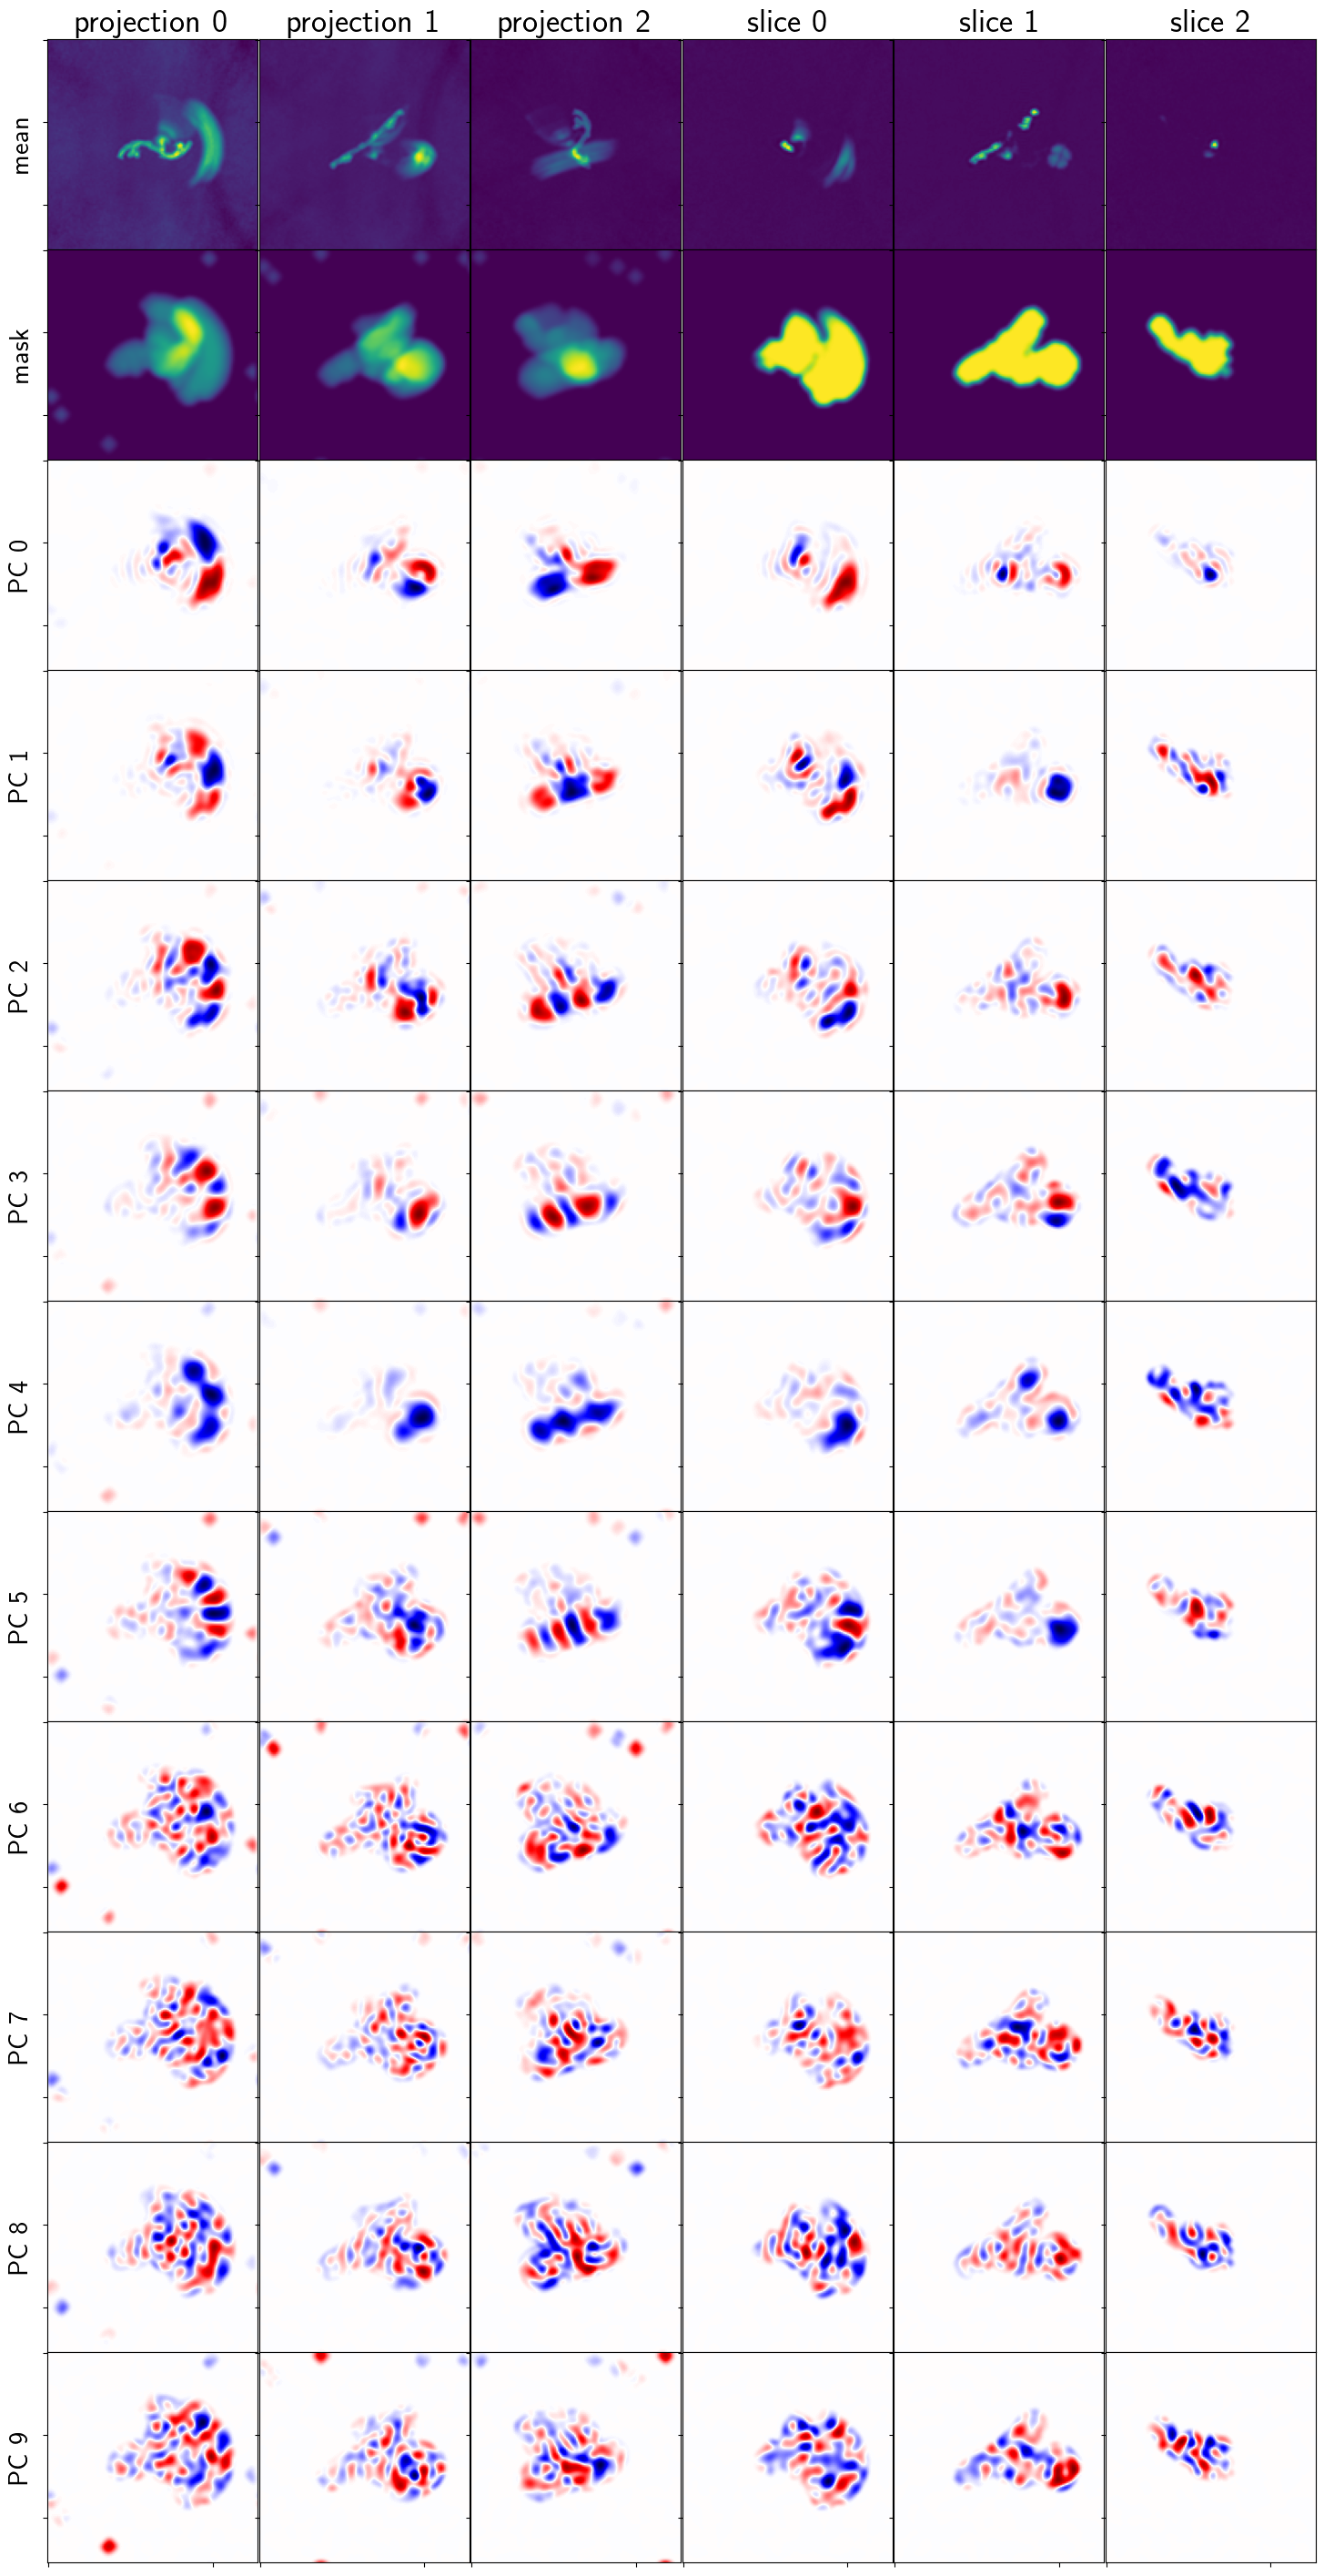

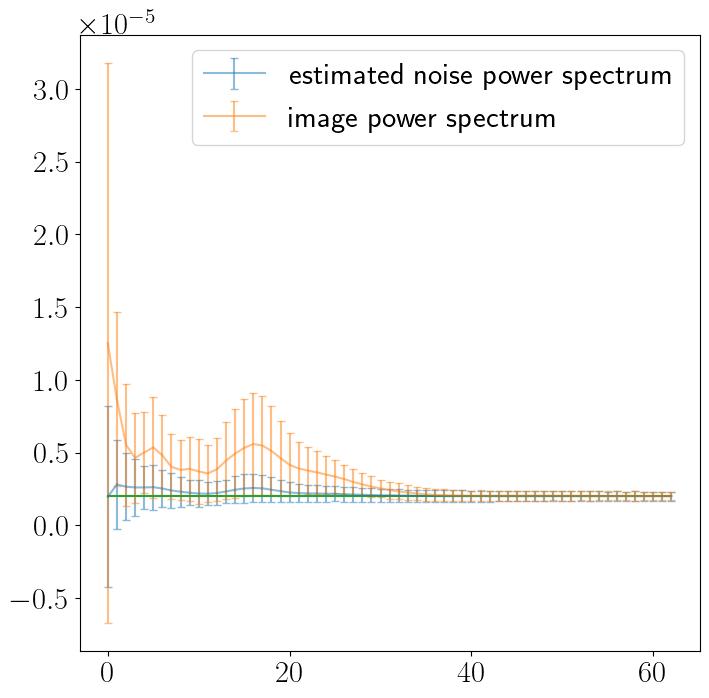

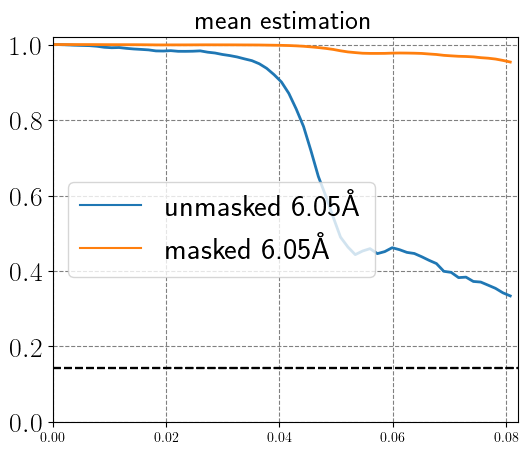

In [5]:
from recovar import synthetic_dataset
# reload(synthetic_dataset)
sim_info_file = recovar_result_dir+'../simulation_info.pkl'
sim_info = recovar.utils.pickle_load(sim_info_file)

HH = synthetic_dataset.load_heterogeneous_reconstruction(sim_info, volumes_path_root = None)

reload(plot_utils)
n_eigs = 10
if 'real' in results['u']:
    plot_utils.plot_summary_t(results,cryos, n_eigs=n_eigs, u_key = "real")
plot_utils.plot_summary_t(results,cryos, n_eigs=n_eigs, u_key = "rescaled")
# plot_utils.plot_summary_t(results,cryos, n_eigs=n_eigs, u_key = "rescaled_10")
plot_utils.plot_noise_profile(results)
plot_utils.plot_mean_fsc(results, cryos)


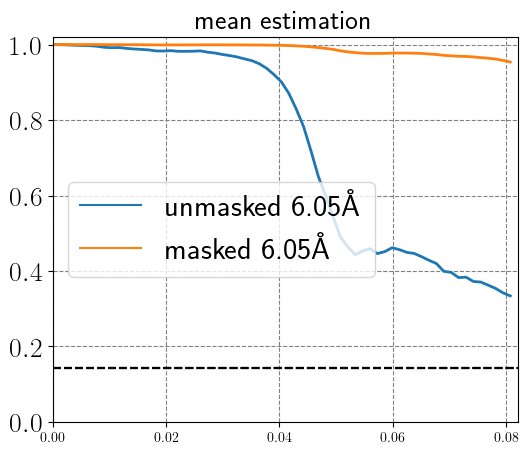

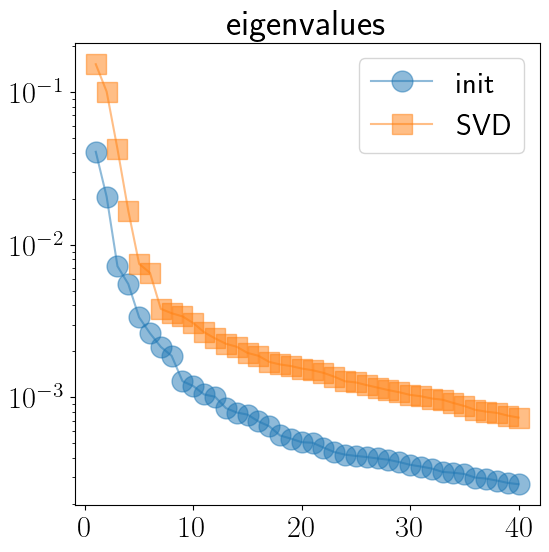

In [6]:
reload(plot_utils)
# Plot FSC of mean, decay of eigenvalues
plot_utils.plot_mean_fsc(results, cryos)
# results['s']['var_s'] = np.mean(np.abs(z)**2, axis=0)
plot_utils.plot_cov_results(results['u'], results['s'])
if results['input_args'].correct_contrast:
    plt.hist(results['contrasts'][zdim], bins = 101)
    np.var(results['contrasts'][zdim])

In [7]:
np.linalg.norm(results['u']['rescaled'][:,:5], axis=0)

array([0.99992925, 0.99988276, 0.99988645, 0.9998798 , 0.9998683 ],
      dtype=float32)

In [8]:
# results['u']['gt'][:,:5].shape

In [9]:
u_gt, s_gt = HH.get_covariance_eigendecomposition()
HH.get_mean()
results['u']['gt'] = u_gt
results['s']['gt'] = s_gt


In [10]:
from recovar import embedding
from recovar import noise
reload(embedding)
noise_variance = sim_info['noise_variance']
noise_variance_rad = noise.make_radial_noise(noise_variance, cryos[0].image_shape)


stuff = []
stuff_emp = []

for b in [4]:
    uu = results['u']['rescaled']

    zs_gt, cov_zs_gt, _ = embedding.get_per_image_embedding(HH.get_mean(),uu, s_gt , b, noise_variance_rad, cryos, np.ones_like(results['volume_mask']), 60, 
                                      disc_type = 'nearest',  contrast_grid = None, contrast_option = "None",
                                      to_real = True, parallel_analysis = False, compute_covariances = True,
                                      ignore_zero_frequency = False )
    

    # zs_inp = results['zs'][20]
    # cov_zs_inp =  results['cov_zs'][20]
    
    zs_inp = zs_gt
    cov_zs_inp = cov_zs_gt
    import jax
    zs = dataset.reorder_to_original_indexing(zs_inp, cryos)
    cov_zs = dataset.reorder_to_original_indexing(cov_zs_inp, cryos)
    labels = HH.image_assignments
    idx = 25
    labels = HH.image_assignments
    
    subset = zs[labels==idx]
    
    # plt.scatter(zs[labels ==25][:,0], zs[labels ==25][:,1])
    estimated_cov_zs = np.mean(np.linalg.inv(cov_zs[labels==idx]), axis=0)
    empirical_cov_zs = np.cov(subset.T)
    estimated_cov_zs = np.mean(np.linalg.inv(cov_zs[labels==idx]), axis=0)
    print("est", estimated_cov_zs.round(4)[:3,:3])#.format(2e3))
    print("emp", empirical_cov_zs.round(4)[:3,:3])
    
    from sklearn.covariance import EmpiricalCovariance, MinCovDet
    robust_cov = MinCovDet().fit(subset)
    print("emp_robust", robust_cov.covariance_.round(4)[:3,:3])
    
    
    print(np.diag(estimated_cov_zs) / np.diag(empirical_cov_zs))
    print(jax.numpy.linalg.eigh(estimated_cov_zs)[0][-1] /   jax.numpy.linalg.eigh(empirical_cov_zs)[0][-1] )
    # print(jax.numpy.linalg.eigh(empirical_cov_zs)[0][-1] )
    stuff.append(estimated_cov_zs)
    stuff_emp.append(empirical_cov_zs)


(INFO) (embedding.py) (21-Feb-24 15:04:31) using contrast? False
(INFO) (embedding.py) (21-Feb-24 15:04:31) embedding batch size? 5714
(INFO) (embedding.py) (21-Feb-24 15:04:31) ignore_zero_frequency? False
(INFO) (covariance_core.py) (21-Feb-24 15:04:31) no mask used
(INFO) (covariance_core.py) (21-Feb-24 15:04:45) no mask used
(INFO) (embedding.py) (21-Feb-24 15:04:54) time to compute xs 22.49163579940796
est [[ 0.001  -0.      0.    ]
 [-0.      0.001   0.    ]
 [ 0.      0.      0.0009]]
emp [[ 0.0029 -0.0002 -0.0003]
 [-0.0002  0.004   0.0001]
 [-0.0003  0.0001  0.0032]]
emp_robust [[ 0.0024 -0.0004  0.    ]
 [-0.0004  0.0032  0.0001]
 [ 0.      0.0001  0.0022]]
[0.33696272 0.23784347 0.28357352 0.49887402]
0.272919615752095


In [11]:
zs_inp = zs_gt
cov_zs_inp = cov_zs_gt
import jax
zs = dataset.reorder_to_original_indexing(zs_inp, cryos)
cov_zs = dataset.reorder_to_original_indexing(cov_zs_inp, cryos)
labels = HH.image_assignments
idx = 25
labels = HH.image_assignments

subset = zs[labels==idx]

# plt.scatter(zs[labels ==25][:,0], zs[labels ==25][:,1])
estimated_cov_zs = np.mean(np.linalg.inv(cov_zs[labels==idx]), axis=0)
empirical_cov_zs = np.cov(subset.T)
estimated_cov_zs = np.mean(np.linalg.inv(cov_zs[labels==idx]), axis=0)
print("est", estimated_cov_zs.round(4))
from sklearn.covariance import EmpiricalCovariance, MinCovDet
robust_cov = MinCovDet().fit(subset)
print("emp_robust", robust_cov.covariance_.round(4))

print("emp", empirical_cov_zs.round(4))

print(np.diag(estimated_cov_zs) / np.diag(empirical_cov_zs))
print(jax.numpy.linalg.eigh(estimated_cov_zs)[0][-1] /   jax.numpy.linalg.eigh(empirical_cov_zs)[0][-1] )
# print(jax.numpy.linalg.eigh(empirical_cov_zs)[0][-1] )


est [[ 1.0e-03 -0.0e+00  0.0e+00  0.0e+00]
 [-0.0e+00  1.0e-03  0.0e+00  1.0e-04]
 [ 0.0e+00  0.0e+00  9.0e-04  0.0e+00]
 [ 0.0e+00  1.0e-04  0.0e+00  1.2e-03]]
emp_robust [[ 0.0024 -0.0004  0.      0.    ]
 [-0.0004  0.0032  0.0001 -0.0003]
 [ 0.      0.0001  0.0022 -0.0002]
 [ 0.     -0.0003 -0.0002  0.0017]]
emp [[ 0.0029 -0.0002 -0.0003  0.0001]
 [-0.0002  0.004   0.0001 -0.0007]
 [-0.0003  0.0001  0.0032 -0.0001]
 [ 0.0001 -0.0007 -0.0001  0.0023]]
[0.33696272 0.23784347 0.28357352 0.49887402]
0.272919615752095


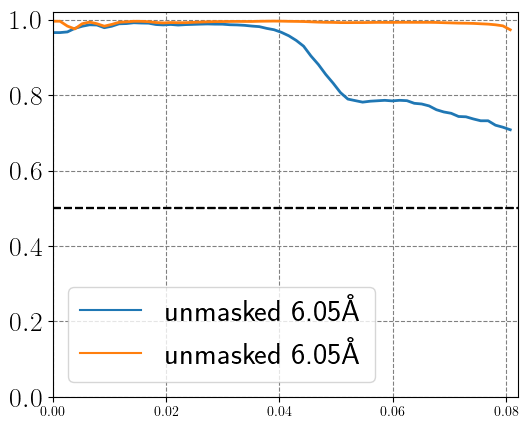

In [12]:
reload(plot_utils)
# GT to combined FSC
ax = plot_utils.plot_fsc(cryos[0], HH.get_mean(), results['means']['combined'], threshold = 1/2)
ax = plot_utils.plot_fsc(cryos[0], HH.get_mean(), results['means']['combined'], mask = results['volume_mask'], threshold = 1/2, ax = ax)

In [13]:
# import jax.numpy as jnp
def l2_distance(X,Y):
    l2_dist = jnp.linalg.norm(X, axis=-1)**2 - 2 * np.conj(X) @ Y.T + jnp.linalg.norm(Y, axis=-1)**2
    return l2_dist.real



# import scipy
# distances = scipy.spatial.distance.pdist(HH.volumes.real ) + scipy.spatial.distance.pdist(HH.volumes.imag )
# l2_distance = l2_distance(HH.volumes,HH.volumes).real

In [14]:
reload(dataset)
ndim = 4
# zs = results['zs'][ndim]
zs_inp = results['zs'][ndim]
cov_zs_inp = results['cov_zs'][ndim]
# zs_inp = zs
# cov_zs_inp = cov_zs

zs = dataset.reorder_to_original_indexing(results['zs'][ndim] , cryos)
cov_zs = dataset.reorder_to_original_indexing(results['cov_zs'][ndim] , cryos)
labels = HH.image_assignments
idx = 25
subset = zs[labels==idx]


[[1.0870397e-03 1.0495252e-05 5.7978763e-05 4.3513457e-05]
 [1.0495252e-05 1.0521621e-03 2.6168804e-05 7.6836586e-05]
 [5.7978763e-05 2.6168804e-05 1.0266689e-03 2.8301320e-05]
 [4.3513457e-05 7.6836586e-05 2.8301320e-05 1.2851056e-03]]
[0.00856929 0.01271997 0.02797978 0.11113971]


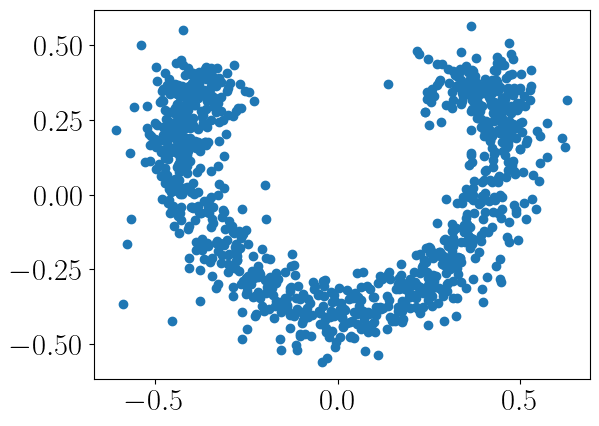

In [15]:
zs_inp = zs
cov_zs_inp = cov_zs

zs = dataset.reorder_to_original_indexing(zs_inp, cryos)
cov_zs = dataset.reorder_to_original_indexing(cov_zs_inp, cryos)
labels = HH.image_assignments
idx = 25
subset = zs[labels==idx]


plt.scatter(zs[labels ==25][:,0], zs[labels ==25][:,1])
estimated_cov_zs = np.mean(np.linalg.inv(cov_zs[labels==idx]), axis=0)
empirical_cov_zs = np.cov(subset.T)
estimated_cov_zs = np.mean(np.linalg.inv(cov_zs[labels==idx]), axis=0)
print(estimated_cov_zs)
print(np.diag(estimated_cov_zs) / np.diag(empirical_cov_zs))

In [16]:
import jax.numpy as jnp
def l2_distance(X,Y):
    l2_dist = jnp.linalg.norm(X, axis=-1)**2 - 2 * np.conj(X) @ Y.T + jnp.linalg.norm(Y, axis=-1)**2
    return l2_dist.real

import scipy
distances = scipy.spatial.distance.pdist(HH.volumes.real ) + scipy.spatial.distance.pdist(HH.volumes.imag )
l2_distance = l2_distance(HH.volumes,HH.volumes).real

In [17]:
np.diag(estimated_cov_zs) / np.diag(empirical_cov_zs)

array([0.00856929, 0.01271997, 0.02797978, 0.11113971])

In [18]:
def project_vol(vol, mean, u):
    if vol.ndim==1:
        vol = vol[None]
    return (jnp.conj(u).T @ (vol - mean).T).T
projected_z = project_vol(HH.volumes[idx], results['means']['combined'], results['u']['rescaled'])

In [19]:
reload(recovar.latent_density)
latent_points = projected_z


log_likelihoods = recovar.latent_density.compute_latent_quadratic_forms_in_batch(latent_points[:,:ndim], results['zs'][ndim], results['cov_zs'][ndim])

(INFO) (latent_density.py) (21-Feb-24 15:05:00) batch size in latent computation: 49479166


In [20]:

log22 =recovar.latent_density.compute_probs_in_batch(results['zs'][ndim], latent_points[:,:ndim], results['cov_zs'][ndim])



(INFO) (latent_density.py) (21-Feb-24 15:05:00) batch size in latent computation: 1171


(INFO) (latent_density.py) (21-Feb-24 15:05:00) batch size in latent computation: 49479166
(INFO) (latent_density.py) (21-Feb-24 15:05:01) batch size in latent computation: 49479166
(INFO) (latent_density.py) (21-Feb-24 15:05:01) batch size in latent computation: 49479166


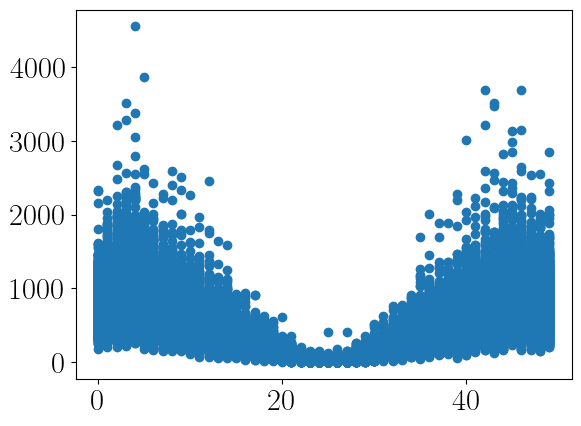

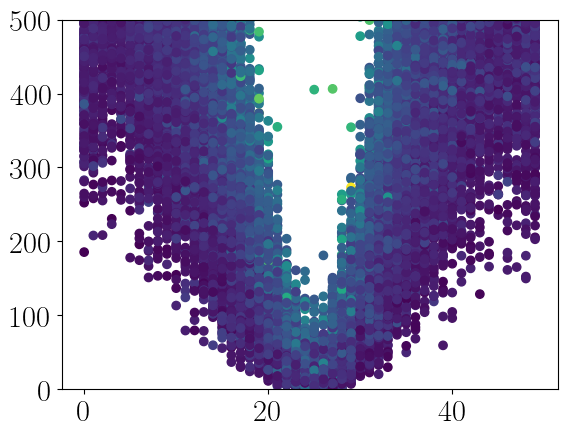

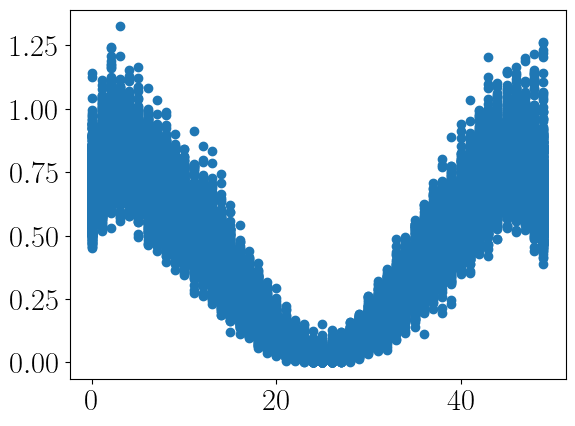

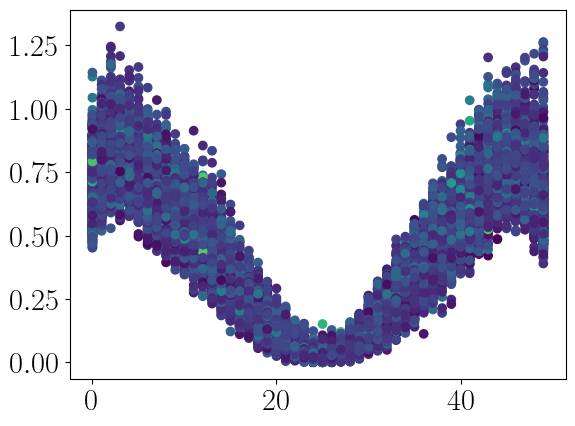

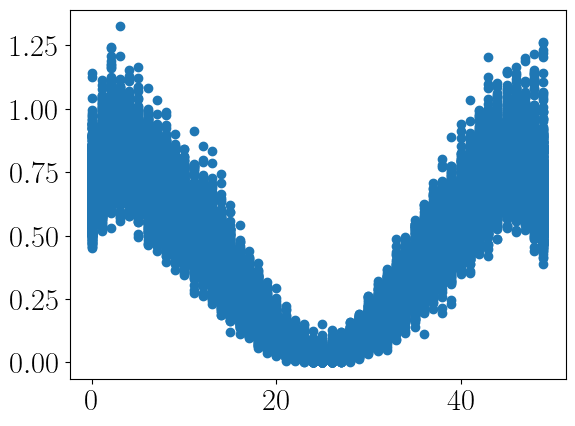

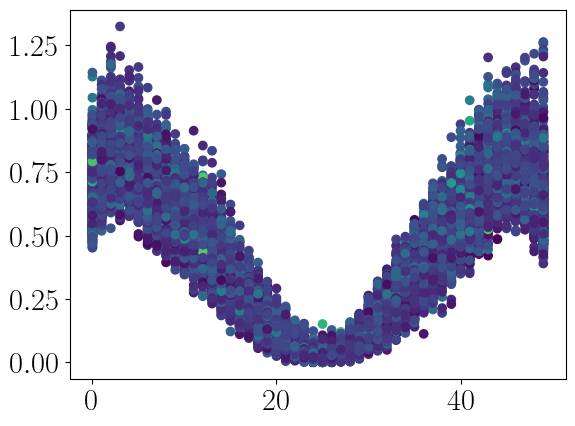

In [21]:
labels = HH.image_assignments[ np.concatenate([cryo.dataset_indices for cryo in cryos])]

log_likelihoods = recovar.latent_density.compute_latent_quadratic_forms_in_batch(latent_points[:,:ndim], results['zs'][ndim], results['cov_zs'][ndim])
plt.scatter(labels, log_likelihoods)


import jax
big_eigs = jnp.max(jnp.linalg.eigvalsh(results['cov_zs'][ndim]), axis =-1)
# plt.figure()
# plt.scatter(big_eigs, log_likelihoods, alpha = 0.01)
plt.figure()
plt.scatter(labels, log_likelihoods, c = big_eigs)
plt.ylim([0,500])


log_likelihoods = recovar.latent_density.compute_latent_quadratic_forms_in_batch(latent_points[:,:ndim], results['zs'][ndim], np.repeat(np.identity(ndim)[None], axis=0, repeats = results['zs'][ndim].shape[0]) )
plt.figure()
plt.scatter(labels, log_likelihoods)

import jax
big_eigs = jnp.max(jnp.linalg.eigvalsh(results['cov_zs'][ndim]), axis =-1)
# plt.figure()
# plt.scatter(big_eigs, log_likelihoods, alpha = 0.01)
plt.figure()
plt.scatter(labels, log_likelihoods, c = big_eigs)



log_likelihoods = recovar.latent_density.compute_latent_quadratic_forms_in_batch(latent_points[:,:ndim], results['zs'][ndim], np.repeat(np.identity(ndim)[None], axis=0, repeats = results['zs'][ndim].shape[0]) )
# scale_zs = np.array(compute_det_cov_xs(cov_zs))

plt.figure()
plt.scatter(labels, log_likelihoods)


import jax
big_eigs = jnp.max(jnp.linalg.eigvalsh(results['cov_zs'][ndim]), axis =-1)
# plt.figure()
# plt.scatter(big_eigs, log_likelihoods, alpha = 0.01)
plt.figure()
plt.scatter(labels, log_likelihoods, c = big_eigs)



In [22]:
log_likelihoods = recovar.latent_density.compute_latent_quadratic_forms_in_batch(latent_points[:,:ndim], results['zs'][ndim], results['cov_zs'][ndim])


(INFO) (latent_density.py) (21-Feb-24 15:05:06) batch size in latent computation: 49479166


In [23]:
# plt.scatter(labels, log_likelihoods)


(INFO) (latent_density.py) (21-Feb-24 15:05:06) batch size in latent computation: 49479166


(0.0, 500.0)

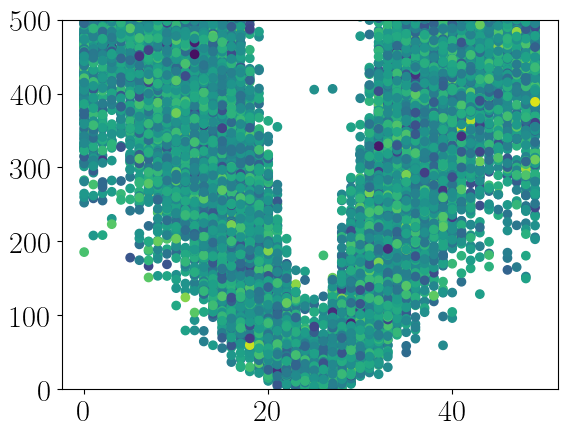

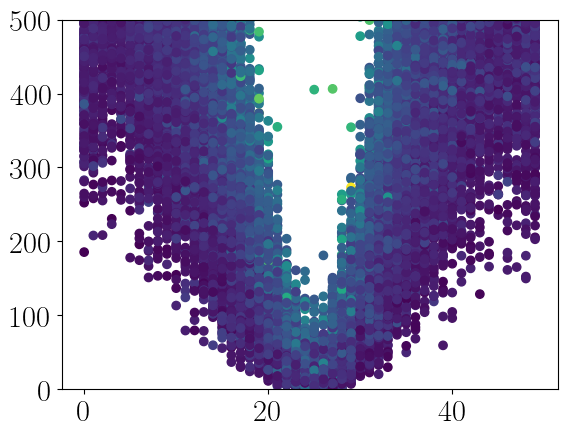

In [24]:
scale_zs = np.log(np.array(recovar.latent_density.compute_det_cov_xs(cov_zs)))[...,None]

log_likelihoods = recovar.latent_density.compute_latent_quadratic_forms_in_batch(latent_points[:,:ndim], results['zs'][ndim], results['cov_zs'][ndim])

# log_likelihoods = - scale_zs + log_likelihoods
plt.figure()
plt.scatter(labels, log_likelihoods, c = scale_zs)
plt.ylim([0,500])

import jax
big_eigs = jnp.max(jnp.linalg.eigvalsh(results['cov_zs'][ndim]), axis =-1)
# plt.figure()
# plt.scatter(big_eigs, log_likelihoods, alpha = 0.01)
plt.figure()
plt.scatter(labels, log_likelihoods, c = big_eigs)
plt.ylim([0,500])


In [25]:
zs_this = zs[labels==idx]
cov_this = np.repeat(np.linalg.inv(empirical_cov_zs[None]), axis =0, repeats = zs_this.shape[0])
cov_this = cov_zs[labels==idx]

zs_this = zs
cov_this = cov_zs
q = 0.95
log_likelihoods = recovar.latent_density.compute_latent_quadratic_forms_in_batch(latent_points[:,:ndim], zs_this, cov_this)
print(np.sum(log_likelihoods <= recovar.latent_density.get_log_likelihood_threshold(k = 4, q=q)) * 10/log_likelihoods.size )
# print(np.sum(log_likelihoods <= recovar.latent_density.get_log_likelihood_threshold(k = 4, q=q)))


(INFO) (latent_density.py) (21-Feb-24 15:05:08) batch size in latent computation: 49479166
0.2276


In [26]:
disc_latent_dist = recovar.latent_density.get_log_likelihood_threshold(k = ndim, q=0.95)

In [27]:
# cryo = dataset.load_cryodrgn_dataset( f"{output_folder}particles.{grid_size}.mrcs", output_folder + "poses.pkl", output_folder + "ctf.pkl", lazy = False)
from recovar import regularization, synthetic_dataset, noise, homogeneous, utils, adaptive_kernel_discretization
sim_info = recovar.utils.pickle_load(output_folder + '/simulation_info.pkl')
gt_recon = synthetic_dataset.load_heterogeneous_reconstruction(sim_info, volumes_path_root = None)
gt_vol =gt_recon.get_mean()
noise_variance = sim_info['noise_variance']
HH = synthetic_dataset.load_heterogeneous_reconstruction(sim_info, volumes_path_root = None)
gt_mean = HH.get_mean()
signal_variance = utils.make_radial_image(regularization.average_over_shells(np.abs(gt_mean)**2, HH.volume_shape), HH.volume_shape)
downsampled_mean = gt_mean * cryos[0].get_valid_frequency_indices(rad = 10)


In [28]:
disc_latent_dist
disc_latent_dist = recovar.latent_density.get_log_likelihood_threshold(k = ndim, q=0.5)
print(disc_latent_dist)

3.3566939800333224


In [29]:
print(np.sum(log_likelihoods_all < disc_latent_dist))

NameError: name 'log_likelihoods_all' is not defined

(INFO) (latent_density.py) (21-Feb-24 15:06:55) batch size in latent computation: 49479166


NameError: name 'heterogeneity_bins' is not defined

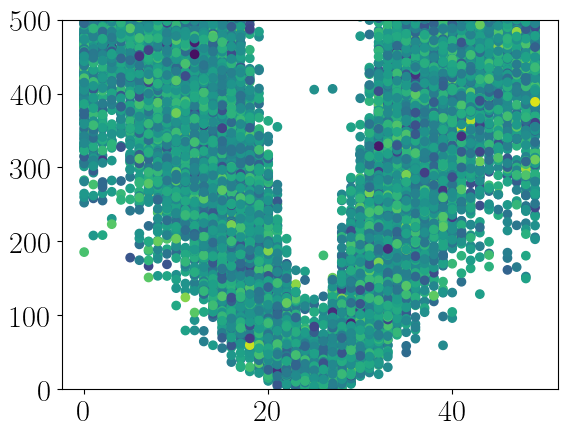

<Figure size 640x480 with 0 Axes>

In [30]:
scale_zs = np.log(np.array(recovar.latent_density.compute_det_cov_xs(cov_zs)))[...,None]

log_likelihoods = recovar.latent_density.compute_latent_quadratic_forms_in_batch(latent_points[:,:ndim], results['zs'][ndim], results['cov_zs'][ndim])

# log_likelihoods = - scale_zs + log_likelihoods
plt.figure()
plt.scatter(labels, log_likelihoods, c = scale_zs)
plt.ylim([0,500])

import jax
big_eigs = jnp.max(jnp.linalg.eigvalsh(results['cov_zs'][ndim]), axis =-1)
# plt.figure()
# plt.scatter(big_eigs, log_likelihoods, alpha = 0.01)
plt.figure()
for k in reversed(range(0,heterogeneity_bins.size)):
    # plt.figure()
    good_idx = (log_likelihoods < heterogeneity_bins[k])[...,0]
    plt.scatter(labels[good_idx], log_likelihoods[...,0][good_idx])
    plt.ylim([0,500])
    print(k)


In [31]:
import jax
from recovar import adaptive_kernel_discretization
discretization_params = []
for pol_degree in [0]:
    for h in [1]:
        discretization_params.append((pol_degree,h, "by_degree"))

cryos = dataset.load_dataset_from_args(results['input_args'], lazy = False)

log_likelihoods_all = recovar.latent_density.compute_latent_quadratic_forms_in_batch(latent_points[:,:ndim], results['zs'][ndim], results['cov_zs'][ndim])[...,0]

log_likelihoods = recovar.latent_density.compute_latent_quadratic_forms_in_batch(latent_points[:,:ndim], results['zs'][ndim], results['cov_zs'][ndim])[...,0]
log_likelihoods = [ log_likelihoods[:cryos[0].n_images], log_likelihoods[cryos[0].n_images:] ]

heterogeneity_distances = log_likelihoods
heterogeneity_bins = np.arange(1,8)**2 * disc_latent_dist
# heterogeneity_bins[1:] *=10
reload(adaptive_kernel_discretization)

# with jax.disable_jit():
x_opt, disc_choices, res_avged, weights, first, disc_params = adaptive_kernel_discretization.heterogeneous_reconstruction_fixed_variance(cryos,
                                                                       noise_variance.astype(np.float32),  signal_variance + np.inf, discretization_params, 
                                                                       return_all = True, heterogeneity_distances = heterogeneity_distances, heterogeneity_bins = heterogeneity_bins)



(INFO) (dataset.py) (21-Feb-24 15:06:58) Loading halfset from file
(INFO) (ctf.py) (21-Feb-24 15:06:59) Image size (pix)  : 128
(INFO) (ctf.py) (21-Feb-24 15:06:59) A/pix             : 6.0
(INFO) (ctf.py) (21-Feb-24 15:06:59) DefocusU (A)      : 23552.5
(INFO) (ctf.py) (21-Feb-24 15:06:59) DefocusV (A)      : 23740.400390625
(INFO) (ctf.py) (21-Feb-24 15:06:59) Dfang (deg)       : 86.61000061035156
(INFO) (ctf.py) (21-Feb-24 15:06:59) voltage (kV)      : 300.0
(INFO) (ctf.py) (21-Feb-24 15:06:59) cs (mm)           : 2.700000047683716
(INFO) (ctf.py) (21-Feb-24 15:06:59) w                 : 0.07000000029802322
(INFO) (ctf.py) (21-Feb-24 15:06:59) Phase shift (deg) : 0.0
(INFO) (ctf.py) (21-Feb-24 15:06:59) Image size (pix)  : 128
(INFO) (ctf.py) (21-Feb-24 15:06:59) A/pix             : 6.0
(INFO) (ctf.py) (21-Feb-24 15:06:59) DefocusU (A)      : 23552.5
(INFO) (ctf.py) (21-Feb-24 15:06:59) DefocusV (A)      : 23740.400390625
(INFO) (ctf.py) (21-Feb-24 15:06:59) Dfang (deg)       : 86.61

In [32]:
def structural_error():
    
    return

import jax.numpy as jnp
def l2_distance(X,Y):
    l2_dist = jnp.linalg.norm(X, axis=-1)**2 - 2 * np.conj(X) @ Y.T + jnp.linalg.norm(Y, axis=-1)**2
    return jnp.sqrt(l2_dist.real)

import scipy
# distances = scipy.spatial.distance.pdist(HH.volumes.real ) + scipy.spatial.distance.pdist(HH.volumes.imag )
# l2_distance = l2_distance(HH.volumes,HH.volumes).real

def error_over_shells(gt, guess, normalized = True):
    volume_shape = utils.guess_vol_shape_from_vol_size(gt.size) #if volume_sj
    avg = regularization.average_over_shells( jnp.abs(gt - guess)**2, volume_shape = volume_shape) 
    
    if normalized:
        avg /= regularization.average_over_shells( jnp.abs(gt)**2, volume_shape = volume_shape)
        
    return avg.real

def volumes_per_distances(guess, target, gt_volumes, distance_volume_to_target, bins = None):
    sorted_dist = np.sort(distance_volume_to_target)
    bins = np.linspace(sorted_dist[2], sorted_dist[-1], 20)  if bins is None else bins
    
    
    errors_l = bins.size * [None]
    fscs_l = bins.size * [None]
    n_vols_l = bins.size * [None]
    for bin_idx, bin_t in enumerate(bins):
        n_vols_l[bin_idx] = np.sum(distance_volume_to_target <= bin_t)
        
        centered = jnp.mean(gt_volumes[distance_volume_to_target < bin_t], axis=0)
        # import pdb; pdb.set_trace()
        centered_gt = target - centered
        centered_guess = guess - centered
        
        errors_l[bin_idx] = error_over_shells(centered_gt, centered_guess, normalized = False)  / error_over_shells(target, target*0, normalized = False)
        volume_shape = utils.guess_vol_shape_from_vol_size(centered_gt.size)
        
        fscs_l[bin_idx] =  regularization.get_fsc_gpu(centered_gt, centered_guess, volume_shape )
        
    return np.array(errors_l), np.array(fscs_l), n_vols_l


target = HH.volumes[idx]
l2_distances = l2_distance(HH.volumes,HH.volumes)[idx]
errors_l, fscs_l, n_vols_l = volumes_per_distances(weights[:,3,0] , target, HH.volumes, l2_distances)


In [ ]:
plt.plot(fscs_l.T)

In [ ]:
plt.plot(errors_l.T)

In [ ]:
errors_l.shape

In [ ]:
l2_distances.shape

In [ ]:
distances = scipy.spatial.distance.pdist(HH.volumes.real ) + scipy.spatial.distance.pdist(HH.volumes.imag )


In [ ]:
# distances

In [ ]:
l2_distance.shape

In [ ]:
ax = None
reload(plot_utils)
plt.figure(figsize=(15, 15))
ax = plt.gca() 
n_neighbors = 4
zzz = np.mean(HH.volumes[idx-n_neighbors:idx+n_neighbors], axis=0) * 0 

for k in range(weights.shape[-2]):
    ax = plot_utils.plot_fsc(cryos[0] , weights[:,k,0] - zzz, HH.volumes[idx]- zzz, mask = None, threshold = 1/2, ax = ax, name = str(disc_params[k]))

fmat = "x"
ax = plot_utils.plot_fsc(cryos[0] ,x_opt[...,0] - zzz, HH.volumes[idx]- zzz, mask = None, threshold = 1/2, ax = ax, name = "opt", fmat = fmat)


In [ ]:
from recovar import output
for k in range(weights.shape[-2]):
    output.save_volumes(weights[:,:,0].T, "/home/mg6942/mytigress/simulated_normal2/tresh_")
    

In [ ]:
output_folder


In [ ]:
help(output.save_volumes)

In [ ]:
def radial_error():
    
    return



In [ ]:
plt.plot(np.array(disc_choices[:,-1].astype(float))/disc_latent_dist)

In [ ]:
print(np.array(disc_choices[:,-1].astype(float))/disc_latent_dist)

In [ ]:
output.save_volume(x_opt ,"xtest", cryos[0].volume_shape)
output.save_volume(HH.volumes[idx] ,"gt", cryos[0].volume_shape)

output.save_volume(weights[:,1,0] ,"first", cryos[0].volume_shape)


In [ ]:
plt.imshow(cryos[0].get_proj(x_opt2))
plt.figure()
plt.imshow(cryos[0].get_proj(HH.volumes[idx]))
plt.figure()
plt.imshow(cryos[0].get_proj(x_opt))

In [ ]:
plot_utils.plot_fsc(cryos[0], x_opt, HH.volumes[idx], mask = None, threshold = 1/2, ax = None, name = "opt")#, voxel_size = 0.75, volume_shape = 3*[512])


In [ ]:
# plot_utils.plot_fsc(cryos[0], x_opt, gt_mean, mask = None, threshold = 1/2, ax = None, name = "opt")#, voxel_size = 0.75, volume_shape = 3*[512])


In [ ]:
cryos[0].volume_size

In [ ]:
pdb

In [ ]:
heterogeneity_bins

In [ ]:
empirical_cov_zs

In [ ]:
# l2_distance_stuff
# for k in range(HH.volumes):
    

In [ ]:
recovar.utils.report_memory_device()

In [ ]:
from recovar import metrics
reload(metrics)
variance, rel_variance, normalized_variance = metrics.get_all_variance_scores(results['u']['rescaled'], HH.get_u(), HH.get_s())
max_eig = 10
plt.plot(variance[:max_eig])
plt.plot(rel_variance[:max_eig])
plt.plot(normalized_variance[:max_eig])

In [ ]:
from recovar import synthetic_dataset
sim_info = recovar_result_dir+'../simulation_info.pkl'
HH = synthetic_dataset.load_heterogeneous_reconstruction(sim_info, volumes_path_root = None)
results['u']['gt'] = HH.get_u()
results['s']['gt'] = HH.get_s()

plot_utils.plot_cov_results(results['u'], results['s'], max_eig=10)



In [ ]:
from recovar import utils
sim_info_dict = utils.pickle_load(sim_info)

In [ ]:
sim_info_pkl.keys()

In [ ]:
plt.plot(results['noise_var']* 0 + sim_info_dict['noise_variance'])
plt.plot(results['noise_var'])
plt.plot(results['noise_var'])
plt.plot(results['noise_var']* 0 + results['cov_noise'])


def radial_errors(gt_noise, estimated_noise, image_shape, ):
    max_error = np.max(np.abs(gt_noise - estimated_noise) / np.abs(gt_noise))
    l1_radial_error = np.mean(np.abs(gt_noise - estimated_noise)) / np.mean(np.abs(gt_noise))
    
    gt_noise_radial = utils.make_radial_image(gt_noise,image_shape, extend_last_frequency = False)
    estimated_noise_radial = utils.make_radial_image(estimated_noise,image_shape, extend_last_frequency = False)

    l1_error = np.mean(np.abs(gt_noise_radial - estimated_noise_radial)) / np.mean(np.abs(gt_noise_radial ))
    return max_error, l1_error, l1_radial_error
    

max_error, l1_error, l1_radial_error = radial_errors(sim_info_dict['noise_variance'], results['noise_var'], cryos[0].image_shape )

In [ ]:
cryos[0].image_shape

In [ ]:
results['noise_var'].shape

In [ ]:
# del results['s']['init']
del results['s']['real']

In [ ]:
from recovar import synthetic_dataset
# reload(synthetic_dataset)
sim_info = recovar_result_dir+'../simulation_info.pkl'
HH = synthetic_dataset.load_heterogeneous_reconstruction(sim_info, volumes_path_root = None)
results['u']['gt'] = HH.get_u()
results['s']['gt'] = HH.get_s()

plot_utils.plot_cov_results(results['u'], results['s'], max_eig=10)



In [ ]:
reload(plot_utils)
# Plot FSC of mean, decay of eigenvalues
plot_utils.plot_mean_fsc(results, cryos)
# results['s']['var_s'] = np.mean(np.abs(z)**2, axis=0)
plot_utils.plot_cov_results(results['u'], results['s'])
if results['input_args'].correct_contrast:
    plt.hist(results['contrasts'][zdim], bins = 101)
    np.var(results['contrasts'][zdim])

### Load result from analyze

In [ ]:
# If you changed the output dir, specify it here
from cryodrgn import utils
analysis_dir = f'{recovar_result_dir}output/analysis_{zdim}'

# Load UMAP
# umap = utils.load_pkl(f'{analysis_dir}/umap_embedding.pkl')
# or run UMAP
umap = analysis.run_umap(z)

In [ ]:
# Load kmeans
K = 40
# kmeans_labels = utils.load_pkl(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/labels.pkl')
kmeans_results = utils.load_pkl(f'{analysis_dir}/kmeans_{K}/centers.pkl')
kmeans_centers = kmeans_results['centers']
kmeans_labels = kmeans_results['labels']

# Or re-run kmeans with the desired number of classes
kmeans_labels, kmeans_centers = analysis.cluster_kmeans(z, 50)

# # Get index for on-data cluster center
if zdim > 1:
    kmeans_centers_2, centers_ind = analysis.get_nearest_point(z, kmeans_centers)

### Load dataset

In [ ]:
# Convert rotation matrices to euler angles
rots = np.concatenate([cryo.rotation_matrices for cryo in cryos])
euler = RR.from_matrix(rots).as_euler('zyz', degrees=True)
trans = np.concatenate([cryo.translations for cryo in cryos])
ctf_params = np.concatenate([cryo.CTF_params for cryo in cryos])
ctf.print_ctf_params(ctf_params[0])

### Learning curve

### PCA

In [ ]:
pc = z
if zdim ==1:
    plt.hist(z, bins =300)
    print("std ", np.sqrt(1/np.median(results['cov_zs'][1])))
    xxx = np.percentile(z, [0.1, 0.5,1,3,5, 50])
    plt.scatter(xxx, 300 * np.ones_like(xxx) , color = 'r')
else:
    g = sns.jointplot(x=pc[:,0], y=pc[:,1], kind='hex')
    g.set_axis_labels('PC1', 'PC2')
    if zdim >2:
        g = sns.jointplot(x=pc[:,0], y=pc[:,2], alpha=.1, s=1)
        g.set_axis_labels('PC1', 'PC3')

In [ ]:
plt.bar(np.arange(z.shape[1])+1,np.var(z, axis=0))
plt.xticks(np.arange(z.shape[1])+1)
plt.xlabel('PC')
plt.ylabel('explained variance')

### View UMAP

In [ ]:
g = sns.jointplot(x=umap[:,0], y=umap[:,1], alpha=.1, s=1)
g.set_axis_labels('UMAP1', 'UMAP2')

In [ ]:
g = sns.jointplot(x=umap[:,0], y=umap[:,1], kind='hex')
g.set_axis_labels('UMAP1', 'UMAP2')

### View pose and shift distribution 

In [ ]:
# Convert rotation matrices to euler angles
rots = np.concatenate([cryo.rotation_matrices for cryo in cryos])
euler = RR.from_matrix(rots).as_euler('zyz', degrees=True)
trans = np.concatenate([cryo.translations for cryo in cryos])
ctf_params = np.concatenate([cryo.CTF_params for cryo in cryos])
ctf.print_ctf_params(ctf_params[0])
# rotations
analysis.plot_euler(euler[:,0],euler[:,1], euler[:,2])
sns.jointplot(x=trans[:,0],
              y=trans[:,1],
              kind='hex').set_axis_labels('tx (fraction)','ty (fraction)')

### View K-means clusters

In [ ]:
K = len(set(kmeans_labels))
c = kmeans_centers[:,0::2]
analysis.plot_by_cluster(pc[:,0], pc[:,2], K, 
                         kmeans_labels, 
                         centers=c,
                         annotate=True)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [ ]:
fig, ax = analysis.plot_by_cluster_subplot(pc[:,0], pc[:,1], K, 
                            kmeans_labels)

In [ ]:
analysis.plot_by_cluster(umap[:,0], umap[:,1], K, 
                         kmeans_labels, 
                         centers_ind=centers_ind,
                         annotate=True)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

In [ ]:
fig, ax = analysis.plot_by_cluster_subplot(umap[:,0], umap[:,1], K, 
                            kmeans_labels)

### Load one of the trajectories and plot it over density

In [ ]:
import json
path_r = json.load(open(f'{analysis_dir}/kmeans_{K}/path0/path.json', 'rb'))
path = np.array(path_r['path'])
subsampled = np.array(path_r['path_subsampled'])
output.plot_trajectories_over_density_from_result(results, [path], [subsampled], zdim=zdim )

In [ ]:
output.plot_two_twings_with_diff_scale([np.array(path_r['density']), np.array(path_r['weights'])], [None, None], labels = ['density', '|I(z)|'],plot_folder = None)

In [ ]:
## Or compute a new one between two end points
from compute_trajectory import compute_trajectory
# Pick two centers and compute traj
z_st = kmeans_centers[0]
z_end = kmeans_centers[36]
compute_trajectory(results, zdim, z_st, z_end, output_folder = '/scratch/gpfs/mg6942/path_test2/', n_vols_along_path = 20 )

# Interactive visualization

Interactive visualization of the latent encodings for the trained model. Each point represents a particle image of the dataset. The hover text includes the index of the image in the particle stack. 

### Load into pandas dataframe

In [ ]:
# Load data into a pandas dataframe
df = analysis.load_dataframe(z=z, 
                             pc=pc, 
                             euler=euler, 
                             trans=trans, 
                             labels=kmeans_labels, 
                             umap=umap,
                             df1=ctf_params[:,2],
                             df2=ctf_params[:,3],
                             dfang=ctf_params[:,4],
                             phase=ctf_params[:,8])
df.head()

In [ ]:
# Annotated points correspond to kmeans cluster centers
widget, fig = analysis.ipy_plot_interactive_annotate(df,centers_ind)
VBox((widget,fig))

# Interactive selection

The next two cells contain helper code to select particles using an interactive lasso tool. 

1. In the first cell, select points with the lasso tool. The table widget is dynamically updated with the most recent selection's indices. 
2. Then once you've finalized your selection, use the next cell to save the particle indices for downstream analysis/viz.

(Double click to clear selection)

In [ ]:
widget, fig, ind_table = analysis.ipy_plot_interactive(df)
VBox((widget,fig,ind_table))

In [ ]:
ind_selected = ind_table.data[0].cells.values[0] # save table values
ind_selected = np.array(ind_selected)
ind_selected_not = np.array(sorted(set(np.arange(len(df))) - set(ind_selected)))

print('Selected indices:')
print(ind_selected)
print('Number of selected points:')
print(len(ind_selected))
print('Number of unselected points:')
print(len(ind_selected_not))

### Visualize selected subset

In [ ]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_selected,0], pc[ind_selected,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))

In [ ]:
# View umap
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_selected,0], umap[ind_selected,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

In [ ]:
# Subset of dataframe
df_sub = df.loc[ind_selected]
df_sub_not = df.loc[ind_selected_not]

In [ ]:
# View pose distribution
analysis.plot_euler(df_sub.theta, df_sub.phi, df_sub.psi)

In [ ]:
widget, fig, ind_table = analysis.ipy_plot_interactive(df_sub)
VBox((widget,fig,ind_table))